# XGBoost Algorithm Demonstration (without using Dask)

## Dataset used - Airlines Delay

Airline on-time statistics and delay causes

<b>Aim : To determine/predict whether a flight will be delayed based on data provided.</b>

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
%%time
cols = ['ActualElapsedTime', 'CRSElapsedTime', 'Distance','AirTime','ArrDelay',
        'DepDelay', 'CRSDepTime', 'CRSArrTime', 'CarrierDelay', 'LateAircraftDelay', 'Origin', 'Dest','UniqueCarrier']


df = pd.read_csv('DelayedFlights.csv', usecols=cols)

CPU times: user 28 ms, sys: 13.8 ms, total: 41.8 ms
Wall time: 43.5 ms


In [3]:
df.head()

,CRSDepTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,CarrierDelay,LateAircraftDelay
0,1955,2225,WN,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810.0,NaN,NaN
1,735,1000,WN,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810.0,NaN,NaN
2,620,750,WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515.0,NaN,NaN
3,1755,1925,WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515.0,2.0,32.0
4,1915,2110,WN,101.0,115.0,87.0,11.0,25.0,IND,JAX,688.0,NaN,NaN


Drop Missing Values

In [4]:
# Drop Missing Values
dfpd = df.dropna()

In [5]:
dfpd.head()

,CRSDepTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,CarrierDelay,LateAircraftDelay
3,1755,1925,WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515.0,2.0,32.0
5,1830,1940,WN,240.0,250.0,230.0,57.0,67.0,IND,LAS,1591.0,10.0,47.0
7,1510,1725,WN,121.0,135.0,107.0,80.0,94.0,IND,MCO,828.0,8.0,72.0
9,1425,1625,WN,228.0,240.0,213.0,15.0,27.0,IND,PHX,1489.0,3.0,12.0
11,1255,1510,WN,123.0,135.0,110.0,16.0,28.0,IND,TPA,838.0,0.0,16.0


In [6]:
dfpd = dfpd.sample(frac=0.2) # XGBoost requires a bit of RAM, we need a larger cluster

dfpd['CRSDepTime'] = dfpd['CRSDepTime'].clip(upper=2399)
dfpd['CRSArrTime'] = dfpd['CRSArrTime'].clip(upper=2399)

DepDelay will act as the dependent column

In [7]:
is_delayed_col = (dfpd.DepDelay.fillna(16) > 15)  # column of labels

# Remove delay information from training dataframe
del dfpd['DepDelay'] 

In [8]:
dfpd.head()

,CRSDepTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,Origin,Dest,Distance,CarrierDelay,LateAircraftDelay
9408,1205,1255,WN,53.0,50.0,37.0,20.0,BWI,ORF,159.0,2.0,15.0
4407,1455,1730,WN,142.0,155.0,127.0,57.0,PBI,PHL,951.0,9.0,48.0
11997,1640,1750,WN,50.0,70.0,37.0,41.0,PHL,PVD,238.0,3.0,38.0
16755,1940,2050,WN,69.0,70.0,50.0,15.0,SJC,LAX,308.0,10.0,5.0
11538,1840,1950,WN,66.0,70.0,53.0,15.0,HOU,LIT,393.0,15.0,0.0


In [9]:
dfpd.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 9408 to 2338
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CRSDepTime         1847 non-null   int64  
 1   CRSArrTime         1847 non-null   int64  
 2   UniqueCarrier      1847 non-null   object 
 3   ActualElapsedTime  1847 non-null   float64
 4   CRSElapsedTime     1847 non-null   float64
 5   AirTime            1847 non-null   float64
 6   ArrDelay           1847 non-null   float64
 7   Origin             1847 non-null   object 
 8   Dest               1847 non-null   object 
 9   Distance           1847 non-null   float64
 10  CarrierDelay       1847 non-null   float64
 11  LateAircraftDelay  1847 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 187.6+ KB


#### Categorize and One Hot Encode

In [10]:
categorical_cols = ['UniqueCarrier', 'Origin', 'Dest']

X = pd.get_dummies(dfpd, columns=categorical_cols)

In [14]:
# len(X.columns)

In [11]:
X

,CRSDepTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,Distance,CarrierDelay,LateAircraftDelay,UniqueCarrier_WN,...,Dest_SEA,Dest_SFO,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_TPA,Dest_TUL,Dest_TUS
9408,1205,1255,53.0,50.0,37.0,20.0,159.0,2.0,15.0,1,...,0,0,0,0,0,0,0,0,0,0
4407,1455,1730,142.0,155.0,127.0,57.0,951.0,9.0,48.0,1,...,0,0,0,0,0,0,0,0,0,0
11997,1640,1750,50.0,70.0,37.0,41.0,238.0,3.0,38.0,1,...,0,0,0,0,0,0,0,0,0,0
16755,1940,2050,69.0,70.0,50.0,15.0,308.0,10.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
11538,1840,1950,66.0,70.0,53.0,15.0,393.0,15.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14328,1710,1810,57.0,60.0,48.0,40.0,276.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0
3055,1120,1250,109.0,90.0,91.0,30.0,446.0,5.0,6.0,1,...,0,0,0,0,0,0,0,0,0,0
3858,1235,2005,279.0,270.0,240.0,20.0,2106.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
6802,1940,2205,79.0,85.0,63.0,45.0,448.0,0.0,45.0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X.head()

,CRSDepTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,Distance,CarrierDelay,LateAircraftDelay,UniqueCarrier_WN,...,Dest_SEA,Dest_SFO,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_TPA,Dest_TUL,Dest_TUS
9408,1205,1255,53.0,50.0,37.0,20.0,159.0,2.0,15.0,1,...,0,0,0,0,0,0,0,0,0,0
4407,1455,1730,142.0,155.0,127.0,57.0,951.0,9.0,48.0,1,...,0,0,0,0,0,0,0,0,0,0
11997,1640,1750,50.0,70.0,37.0,41.0,238.0,3.0,38.0,1,...,0,0,0,0,0,0,0,0,0,0
16755,1940,2050,69.0,70.0,50.0,15.0,308.0,10.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
11538,1840,1950,66.0,70.0,53.0,15.0,393.0,15.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
is_delayed_col.head()

9408     True
4407     True
11997    True
16755    True
11538    True
Name: DepDelay, dtype: bool

#### Assign independent columns(X) and dependent column(y). Split Training & Testing Data

In [14]:
%%time
# X= dfpd
y = is_delayed_col

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

CPU times: user 5.6 ms, sys: 0 ns, total: 5.6 ms
Wall time: 5.24 ms


#### Define an XGBoost classification model 

In [15]:
%%time
from xgboost import XGBClassifier

classifier = XGBClassifier(tree_method="gpu_hist", enable_categorical=True)
classifier.fit(X_train, y_train)

CPU times: user 597 ms, sys: 289 ms, total: 886 ms
Wall time: 1.2 s


In [16]:
print(classifier)

XGBClassifier(enable_categorical=True, tree_method='gpu_hist')


##### Calculating Accuracy of Predictions

In [17]:
%%time

y_pred = classifier.predict(X_test)
predictions = [value for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.84%
CPU times: user 9.64 ms, sys: 626 µs, total: 10.3 ms
Wall time: 10.3 ms


#### Plot XGBoost Tree

In [18]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

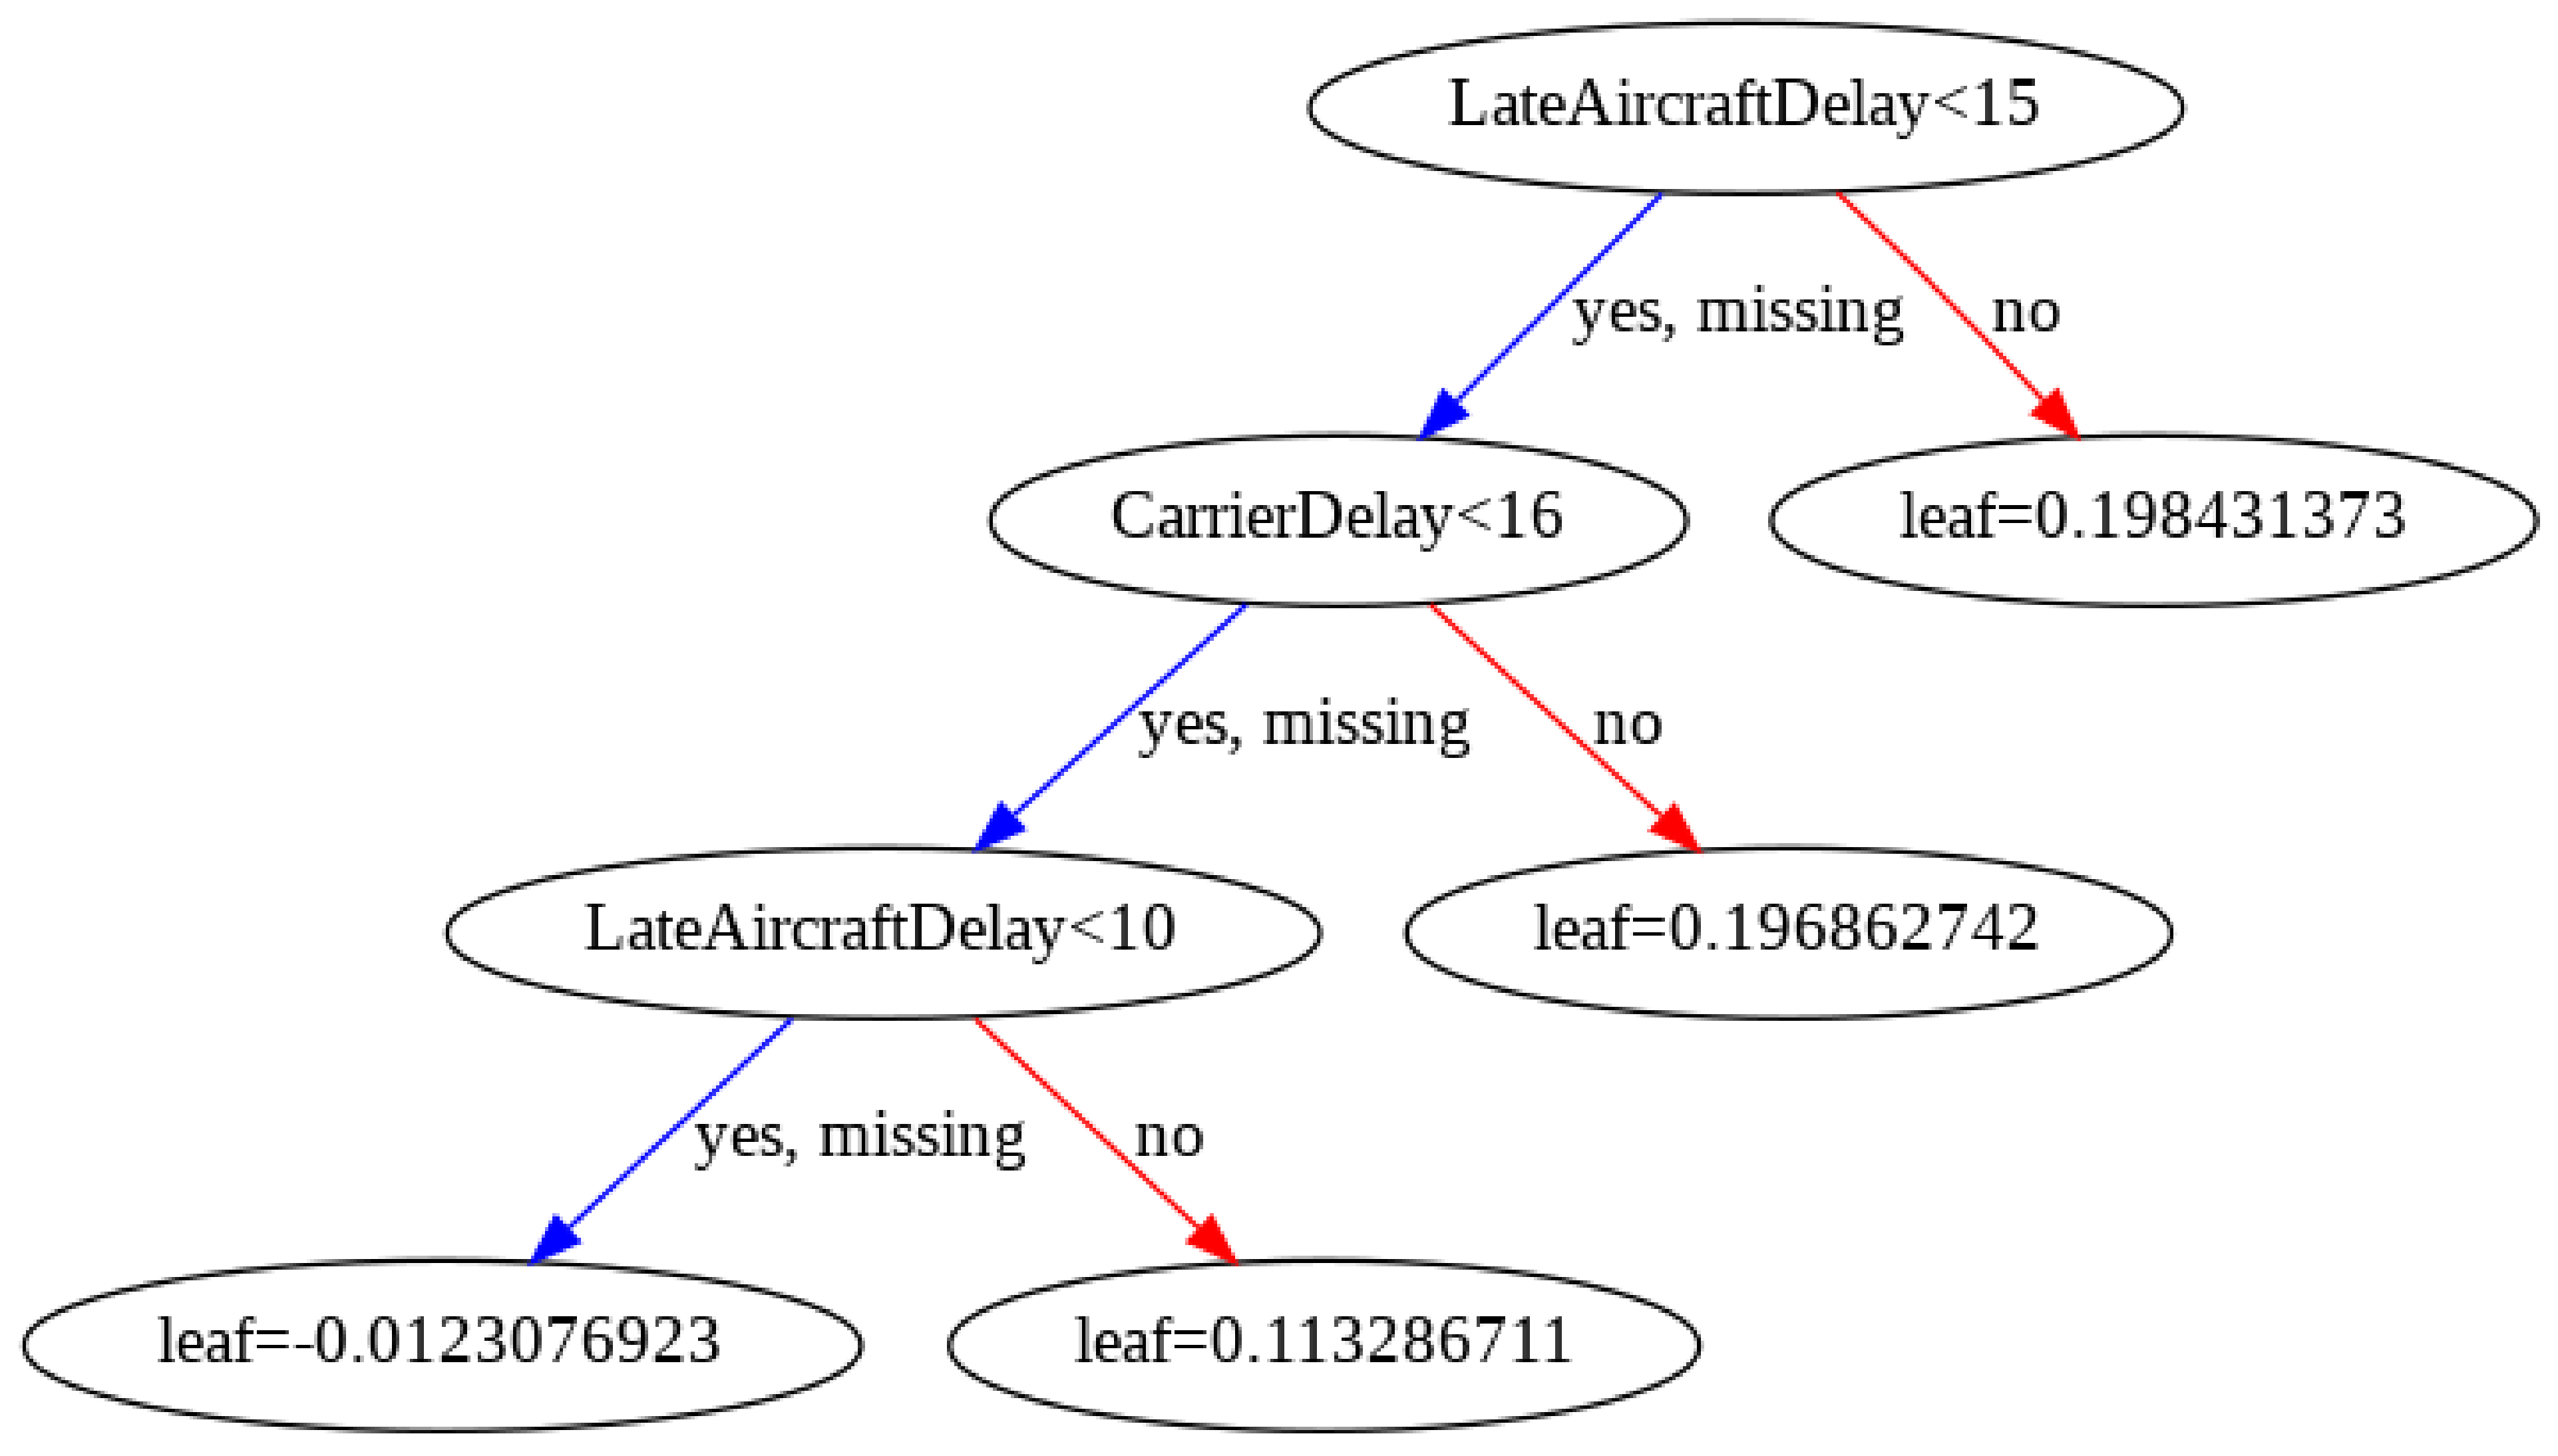

In [19]:
# plot_tree(classifier)


##set up the parameters
rcParams['figure.figsize'] = 70,40
plot_tree(classifier)


#### Evaluate and Plot ROC Curve

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

import matplotlib


In [21]:
# Resetting Plot Size Dimensions
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [22]:
roc_auc = roc_auc_score(y_test, y_pred)

print("ROC AUC Score is: %.2f%%" % (roc_auc*100.0))

ROC AUC Score is: 92.75%


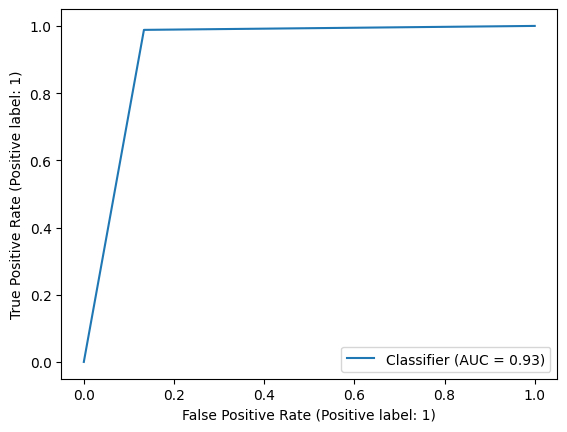

In [23]:
# plt = metrics.plot_roc_curve(classifier, X_test, y_test)
RocCurveDisplay.from_predictions(y_test, y_pred)

### Setting Parameters while Performing XGBoost & Calculating Precision

In [30]:
%%time

import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file

from sklearn.metrics import precision_score


# use DMatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)



# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3,
    'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
num_round = 200  # the number of training iterations

# param = {'objective': 'binary:logistic', 'nround': 1000,
#           'max_depth': 16, 'eta': 0.3, 'subsample': 0.5,
#           'min_child_weight': 1, 'tree_method': 'hist',
#           'grow_policy': 'lossguide'}

# num_round = 200


#------------- numpy array ------------------
# training and testing - numpy matrices
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array precision:", precision_score(y_test, best_preds, average='macro'))

Numpy array precision: 0.9637254901960784
CPU times: user 2.69 s, sys: 11.9 ms, total: 2.71 s
Wall time: 2.8 s


In [31]:
roc_auc = roc_auc_score(y_test,best_preds)

print("ROC AUC Score is: %.2f%%" % (roc_auc*100.0))

ROC AUC Score is: 96.37%


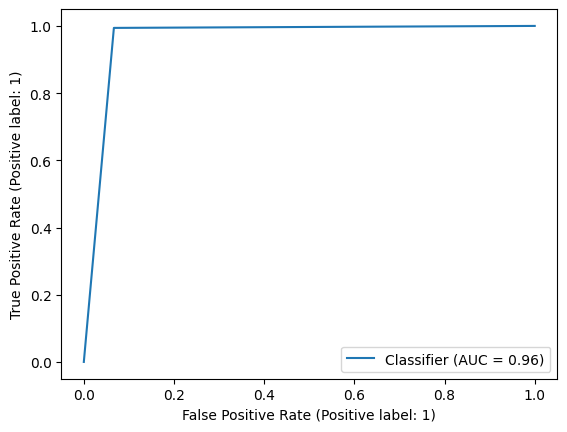

In [33]:
# Resetting plot parameters
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Plotting the curve
RocCurveDisplay.from_predictions(y_test, best_preds)

In [34]:
rcParams['figure.figsize'] = 110,80

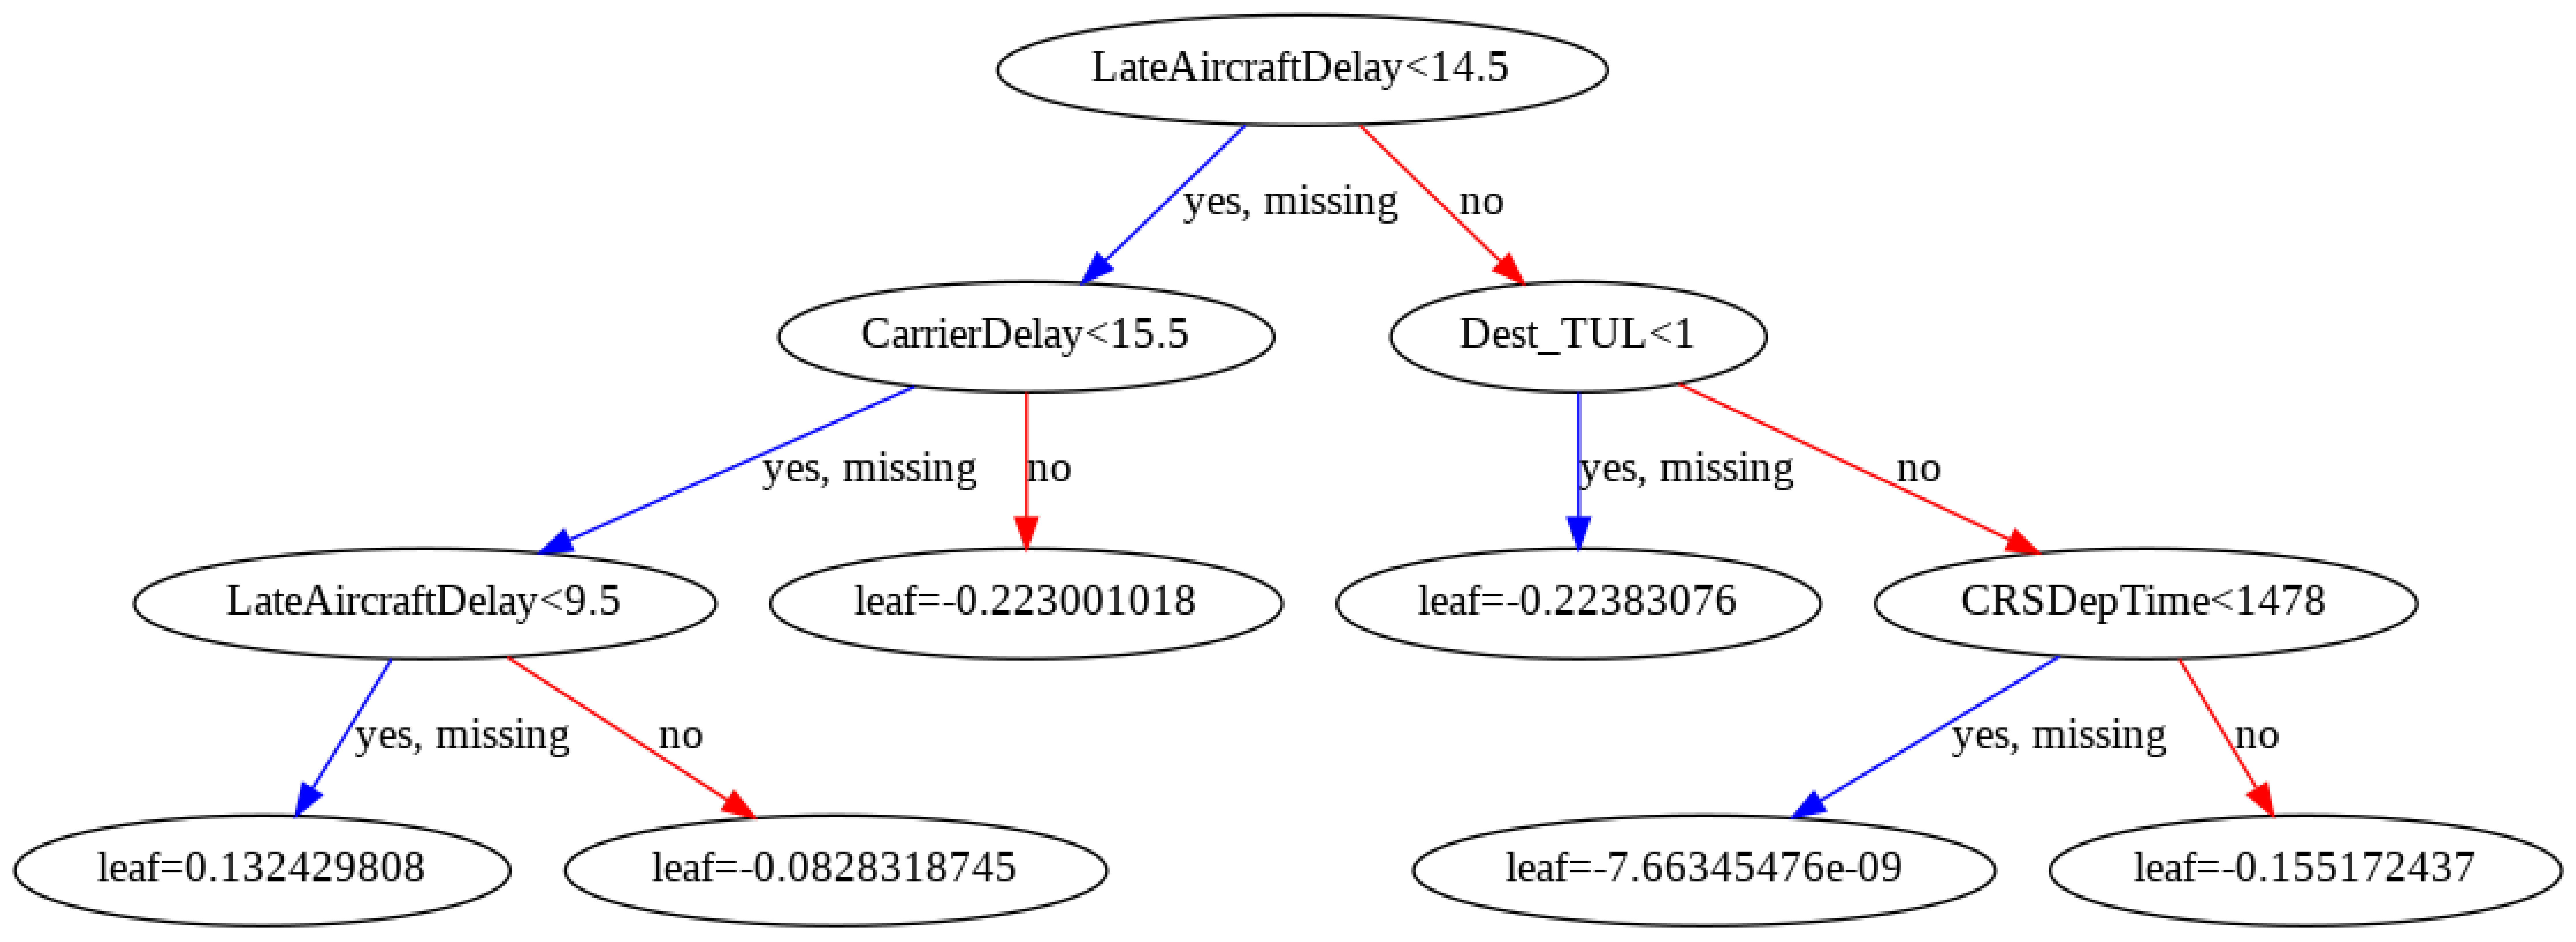

In [35]:
plot_tree(bst)